In [1]:
import pandas as pd

import numpy as np
import os

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
import seaborn as sns
from sklearn.metrics import recall_score, precision_score, f1_score 

from imblearn.over_sampling import SMOTE
from collections import Counter  

from sklearn.tree import DecisionTreeClassifier
import funciones

from feature_engine.discretisation import DecisionTreeDiscretiser

import pygad

import time

In [3]:
datos = pd.read_csv('/home/juan/proyectoTesis/datasets/creditcard.csv')

datos.shape

#Ver balanceo de la clase objetivo. Diabetes_012
porcentaje = 100*datos['Class'].value_counts()/len(datos)
print(porcentaje.astype(str) + '%')

Class
0       99.827251436938%
1    0.1727485630620034%
Name: count, dtype: object


In [4]:
#Discretizar caracteristicas por medio de arboles de decision
X = datos.drop("Class", axis=1)
y = datos["Class"]

columnas_disc = X.columns.to_list()

disc = DecisionTreeDiscretiser(bin_output="bin_number",
                                        cv=3,
                                        scoring="roc_auc",
                                        variables= columnas_disc, 
                                        regression=False)

disc.fit(X, y)

X_disc = disc.transform(X)

nombres_de_features = X_disc.columns.tolist()
# Número total de características
num_total_features = len(nombres_de_features)

In [5]:
def fitness_mod(ga_instance, solution, solution_idx):
    # decodificar solucion 
    selected_features = []

    for i in range(len(solution)):
        
        if solution[i]==1:
            selected_features.append(columnas_disc[i])
    
    if not selected_features:
        return 0
        
    # Llamar a tasa_inconsistencia
    inconsistency_rate = funciones.tasa_inconsistencia(
        df=X_disc.join(y), 
        subconjunto_caracteristicas=selected_features, 
        clase='Class'
    )
    
    # Si inconsistency_rate es 0 (perfecto), el fitness sera maximo.
    fitness = 1.0 - inconsistency_rate
    
    return fitness

def fitness_mod_nsga2(ga_instance, solution, solution_idx):
    # decodificar solucion 
    selected_features = []

    for i in range(len(solution)):
        if solution[i]==1:
            selected_features.append(columnas_disc[i])
    
    num_selected_features = len(selected_features)
    if not selected_features:
        return [0,0]
        
    # Llamar a tasa_inconsistencia
    inconsistency_rate = funciones.tasa_inconsistencia(
        df=X_disc.join(y), 
        subconjunto_caracteristicas=selected_features, 
        clase='Class'
    )
    
    # Si inconsistency_rate es 0 (perfecto), el fitness sera maximo.
    fitness1 = 1.0 - inconsistency_rate

    fitness2=num_total_features - num_selected_features
    
    return [fitness1, fitness2]

In [11]:
def callback_generation(ga_instance):
    current_time = time.time()
    duration = current_time - ga_instance.last_execution_time
    
    print(f"Generación                : {ga_instance.generations_completed}")
    
    if hasattr(ga_instance, 'pareto_fronts') and ga_instance.pareto_fronts and len(ga_instance.pareto_fronts) > 0:
        
        # 1. Obtener los índices de las soluciones en el mejor frente
        indices_del_mejor_frente = ga_instance.pareto_fronts[0][:, 0].astype(int)
        
        # 2. Obtener las soluciones y sus fitness ya calculados
        soluciones_del_frente = ga_instance.population[indices_del_mejor_frente]
        fitness_del_frente = ga_instance.last_generation_fitness[indices_del_mejor_frente]
        
        # 3. Calcular el rango del número de características
        num_features_en_frente = [np.sum(sol) for sol in soluciones_del_frente]
        
        print(f"Soluciones en Frente Pareto : {len(soluciones_del_frente)}")
        
        if num_features_en_frente:
            print(f"  - Rango de Características: de {min(num_features_en_frente):.0f} a {max(num_features_en_frente):.0f}")
        
        # --- NUEVA LÓGICA: CALCULAR Y MOSTRAR RANGO DE FITNESS ---
        if fitness_del_frente.size > 0:
            # Separamos los valores de fitness para cada objetivo
            # fitness_del_frente[:, 0] contiene todos los valores del primer objetivo
            # fitness_del_frente[:, 1] contiene todos los valores del segundo objetivo
            
            # Rango para el Objetivo 1 (Consistencia)
            min_fitness_obj1 = np.min(fitness_del_frente[:, 0])
            max_fitness_obj1 = np.max(fitness_del_frente[:, 0])
            
            # Rango para el Objetivo 2 (Simplicidad)
            min_fitness_obj2 = np.min(fitness_del_frente[:, 1])
            max_fitness_obj2 = np.max(fitness_del_frente[:, 1])

            print(f"  - Rango Fitness (Obj. 1)  : de {min_fitness_obj1:.8f} a {max_fitness_obj1:.8f}")
            print(f"  - Rango Fitness (Obj. 2)  : de {min_fitness_obj2:.0f} a {max_fitness_obj2:.0f}")
        # --- FIN DE LA NUEVA LÓGICA ---

    print(f"Duración de la Generación : {duration:.2f} segundos")
    print("------------------------------------------")
    
    ga_instance.last_execution_time = current_time

In [13]:
#Algoritmo genetico para la seleccion de variables.
ga_instance = pygad.GA(
    num_generations=50,
    num_parents_mating=30, #numero de padres que seran seleccionados para reproducirse.
    parent_selection_type="tournament_nsga2",
    K_tournament= 2,
    sol_per_pop=30,
    num_genes=len(X_disc.columns),
    gene_space=[0, 1],
    mutation_type="random",
    mutation_probability = 0.000358, #1% para cada cromosoma, 
    fitness_func=fitness_mod_nsga2,
    save_solutions=True,
    on_generation=callback_generation
)


In [14]:
print("***********************Población inicial:**************************")
print(ga_instance.population)
print("*******************************************************************")

***********************Población inicial:**************************
[[0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1.
  0. 1. 0. 1. 1. 0.]
 [1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 1. 1. 0. 1. 0.
  1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.
  1. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 1. 0. 1. 0. 0. 1. 1. 1. 0. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.
  0. 1. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
  0. 1. 1. 1. 1. 0.]
 [1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 0. 0. 1. 0. 1. 0.
  1. 0. 1. 1. 1. 1.]
 [0. 0. 1. 0. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1.
  1. 1. 0. 1. 1. 1.]
 [1. 0. 0. 1. 0. 1. 0. 0. 1. 1. 0. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 1. 1. 1.
  0. 0. 1. 0. 1. 0.]
 [0. 1. 1. 0. 1. 0. 1. 0. 1. 1. 1. 1. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 1. 0.
  1. 1. 0. 1. 0. 1.]
 [0. 1. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.
  0

In [15]:
cardinalidad_cromosomas_poblacion_inicial = []
for cromosoma in ga_instance.population:
    num_caracteristicas= np.sum(cromosoma)
    cardinalidad_cromosomas_poblacion_inicial.append(num_caracteristicas)



promedio_cardinalidad = np.sum(cardinalidad_cromosomas_poblacion_inicial)/len(ga_instance.population[0])

print(f"El promedio de cardinalidad de la poblacion generada aleatoriamente es: {promedio_cardinalidad}")

El promedio de cardinalidad de la poblacion generada aleatoriamente es: 15.1


In [16]:
#inicializar marca de tiempo
ga_instance.last_execution_time = time.time()

ga_instance.run()

Generación                : 1
Soluciones en Frente Pareto : 5
  - Rango de Características: de 11 a 15
  - Rango Fitness (Obj. 1)  : de 0.99975422 a 0.99979986
  - Rango Fitness (Obj. 2)  : de 15 a 19
Duración de la Generación : 539.80 segundos
------------------------------------------
Generación                : 2
Soluciones en Frente Pareto : 7
  - Rango de Características: de 9 a 19
  - Rango Fitness (Obj. 1)  : de 0.99973666 a 0.99985955
  - Rango Fitness (Obj. 2)  : de 11 a 21
Duración de la Generación : 243.80 segundos
------------------------------------------
Generación                : 3
Soluciones en Frente Pareto : 9
  - Rango de Características: de 9 a 20
  - Rango Fitness (Obj. 1)  : de 0.99973315 a 0.99983498
  - Rango Fitness (Obj. 2)  : de 10 a 21
Duración de la Generación : 178.91 segundos
------------------------------------------
Generación                : 4
Soluciones en Frente Pareto : 10
  - Rango de Características: de 9 a 21
  - Rango Fitness (Obj. 1)  : de 0.

In [ ]:
#Distribuciones de fitness de la ultima generacion

ga_instance.save(filename="NSGA2-cfraude-creditos-v2-50generations")

fitness_values = ga_instance.last_generation_fitness

fitness_values 

In [ ]:
print("--- Resultados de NSGA-II ---")

# Verificar si se encontraron frentes de Pareto
if ga_instance.pareto_fronts is None or len(ga_instance.pareto_fronts) == 0:
    print("No se encontraron frentes de Pareto.")
else:
    # Obtener los indices de las soluciones en el mejor frente
    indices_del_mejor_frente = ga_instance.pareto_fronts[0][:, 0].astype(int)
    
    # Usar esos índices para obtener las soluciones y el fitness
    soluciones_del_mejor_frente = ga_instance.population[indices_del_mejor_frente].astype
    fitness_del_mejor_frente = ga_instance.last_generation_fitness[indices_del_mejor_frente]
    
    print(f"Se encontraron {len(soluciones_del_mejor_frente)} soluciones óptimas en el mejor Frente de Pareto.\n")
    
    #mostrar solucion con su fitness
    for solucion, fitness in zip(soluciones_del_mejor_frente, fitness_del_mejor_frente):
        num_features = int(np.sum(solucion))
        
        print(f"Solución con {num_features} características:")
        print(f"  - Objetivo 1 (Consistencia): {fitness[0]:.6f}")
        print(f"  - Objetivo 2 (Simplicidad) : {fitness[1]}")
        print("-" * 30)

In [ ]:

import numpy
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
fig.suptitle('Distribución del Fitness en la Última Generación', fontsize=16)

# Histograma
sns.histplot(fitness_values, ax=axes[0], kde=False)
axes[0].set_title('Histograma de Fitness')
axes[0].set_xlabel('Fitness')
y_max = axes[0].get_ylim()[1]
# Crear una lista de ticks de uno en uno, desde 0 hasta el máximo
y_ticks = numpy.arange(0, y_max + 1, 1)
axes[0].set_yticks(y_ticks)
# Establecer esos ticks en el eje Y del h
axes[0].set_ylabel('Frecuencia')
axes[0].ticklabel_format(style='plain', axis='x')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Box Plot
sns.boxplot(y=fitness_values, ax=axes[1])
axes[1].set_title('Box Plot de Fitness')
axes[1].set_xlabel('Población')
axes[1].set_ylabel('Fitness')


#guarda la figura.
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
plt.savefig('fitness_distribution.png')

In [14]:
busqueda1 = pygad.load("/home/juan/proyectoTesis/algoritmos_geneticos/NSGA2-cfraude-creditos-v1")

/home/juan/miniconda3/envs/py310/lib/python3.10/site-packages/pygad/visualize/plot.py:120: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  matplt.legend()


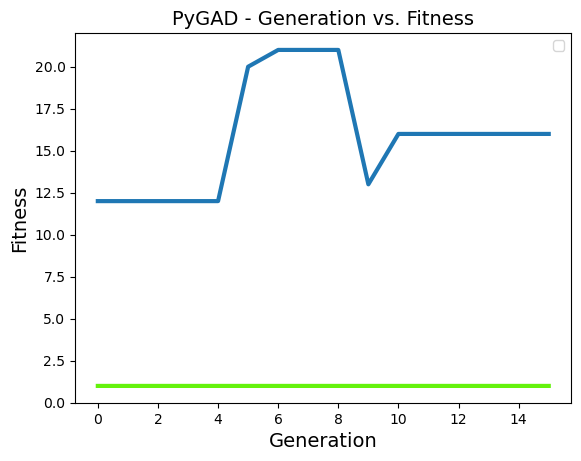

In [19]:
busqueda1.plot_fitness();

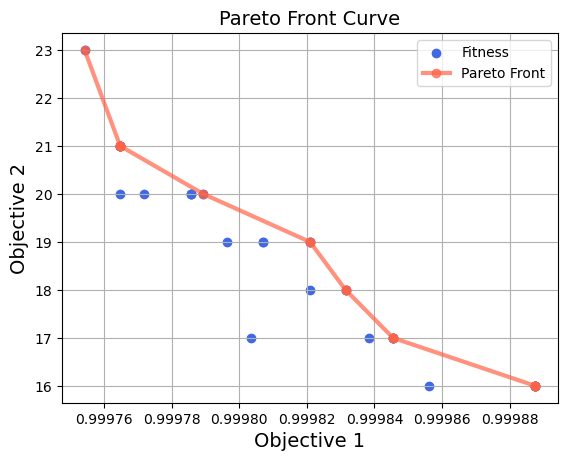

In [20]:
busqueda1.plot_pareto_front_curve();

In [24]:
valores_fitness = busqueda1.last_generation_fitness

len(np.unique(valores_fitness, axis=0))

16

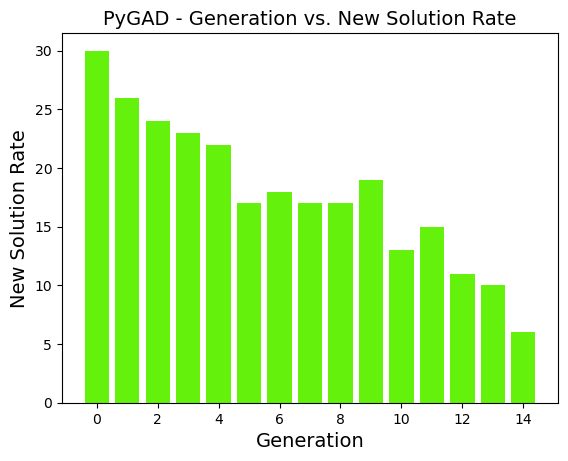

In [ ]:
busqueda1.plot_new_solution_rate(plot_type="bar");